<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im HS 2023.
</p>

## Ziel
Für diese Mini Challenge bearbeite ich das Paper [Vinyals, O., Toshev, A., Bengio, S., & Erhan, D. (2014, November 17). Show and Tell: A Neural Image Caption Generator. arXiv.Org.](https://doi.org/10.48550/arXiv.1411.4555). In diesem Paper wird ein Modell vorgestellt, das Bilder in natürliche Sprache beschreibt (Image Captioning). Es kombiniert Convolutional Neural Networks (CNN) und Long Short-Term Memory Networks (LSTM), wobei der Output des CNN mit den tokenisierten Bildbeschreibungen (Captions) konkatiniert und dann in das LSTM-Netzwerk eingespeist wird. Das Modell wird auf dem Datensatz [Hodosh, M., Young, P., & Hockenmaier, J. (2013, August 30). Flickr8k Dataset.
](http://hockenmaier.cs.illinois.edu/8k-pictures.html) trainiert.

## Setup
Hier werden alle benötigten Bibliotheken importiert und Einstellungen vorgenommen.

In [1]:
# Standard Libraries
import os
import sys
import logging
import warnings

from collections import defaultdict

# 3rd Party Libraries
import matplotlib as mpl
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as li
import torch
import torchmetrics
import torchvision
import wandb

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.text import BLEUScore, BERTScore
from torchvision import transforms
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Pandas Version: {pd.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchmetrics Version: {torchmetrics.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"   | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"   | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Settings
torch.set_float32_matmul_precision("high")
nltk.download('punkt')
torch.manual_seed(0)

# Silence warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Final message
print("Setup complete!\n")

Packages: 
 | Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
 | Matplotlib Version: 3.8.2
 | NLTK Version: 3.8.1
 | Numpy Version: 1.26.2
 | Pandas Version: 2.1.3
 | PyTorch Lightning Version: 2.1.0
 | PyTorch Version: 2.1.1+cu121
 | Torchmetrics Version: 1.2.0
 | Torchvision Version: 0.16.1+cu121
 | Wandb Version: 0.16.0

Backends: 


 | CUDA: True
   | CUDA Built: True
 | MPS: False
   | MPS Built: False

Ressources: 
 | CPU Threads: 16
 | GPU 1: NVIDIA RTX A4500



[nltk_data] Downloading package punkt to
[nltk_data]     /home2/g.torresgamez/nltk_data...


env: WANDB_SILENT=True
Setup complete!



[nltk_data]   Package punkt is already up-to-date!


Hier werden alle benötigten Konstanten definiert.

In [2]:
# Files
IMG_PATH = "data/images"
ANN_FILE = "data/captions.txt"

# Data Module
BATCH_SIZE = 64
NUM_WORKERS = 7 # number of CPU cores - 1 | 0 on Apple Silicon
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Special Tokens
START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = [START_TOKEN, END_TOKEN, PAD_TOKEN, UNK_TOKEN]

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

Hier wird der Tokenizer definiert. Wir nehmen für diese Mini Challenge den Word Tokenizer `(nltk_word_tokenize)` von NLTK.

In [3]:
tokenizer = nltk_word_tokenize

## Arbeitsschritte

### Schritt 1: Daten 
In diesem Schritt lesen wir die Daten ein und bereiten sie für das Training vor.

Hier finden wir alle verschiedenen Captions für jedes Bild.

In [4]:
# read annotations as df
ann = pd.read_csv(ANN_FILE, sep=",")
ann

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


Hier definieren wir anhand der Daten und des Tokenizers die Vokabulargrösse und die maximale Länge der Captions (mit Start- und Endtoken).

In [5]:
all_tokens_set = set(ann["caption"].apply(tokenizer).explode().tolist())

VOCAB_SIZE = len(all_tokens_set) + len(SPECIAL_TOKENS) 
MAX_CAPTION_LENGTH = ann["caption"].apply(tokenizer).apply(len).max() + 2  # + start & end token

print(f"Vocabulary Size:\t\t\t{VOCAB_SIZE}")
print(f"Max. Number of Tokens in a caption:\t{MAX_CAPTION_LENGTH}")

Vocabulary Size:			9634
Max. Number of Tokens in a caption:	40


Hier erstellen wir ein Vokabular, welches die Tokens in Zahlen umwandelt (und umgekehrt).
Zusätzlich erstellen wir eine Funktion, welches jede Caption mit Start- und Endtoken versieht und diese auf die maximale Länge paddet.

In [6]:
# vocabulary which maps tokens to indices
vocab = {token: idx for idx, token in enumerate(sorted(all_tokens_set))}
for token in SPECIAL_TOKENS:
    vocab[token] = len(vocab)
    
# inverse vocabulary which maps indices to tokens
inv_vocab = {idx: token for token, idx in vocab.items()} # für rücktransformation

# convert tokens str to int, if token not in vocab, use unk_token
def tokens_str_to_int(tokens):
    return [vocab.get(token, vocab[UNK_TOKEN]) for token in tokens] 

# converts tokens int to str, if token not in vocab, use unk_token
def tokens_int_to_str(tokens_idx):
    return [inv_vocab.get(idx, UNK_TOKEN) for idx in tokens_idx]

# converts a string to a list of tokens with the length max_num_tokens
def text_process(text):
    tokenized_text = [START_TOKEN] + tokenizer(text) + [END_TOKEN]
    n_pad = MAX_CAPTION_LENGTH - len(tokenized_text)
    return tokenized_text + n_pad * [PAD_TOKEN]

example_caption = ann["caption"][0]
print(f"Example caption:\n{example_caption}\n")
print(f"Tokenized caption:\n{text_process(example_caption)}\n")
print(f"Tokenized caption (int):\n{tokens_str_to_int(text_process(example_caption))}\n")

Example caption:
A child in a pink dress is climbing up a set of stairs in an entry way .

Tokenized caption:
['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Tokenized caption (int):
[9630, 68, 2580, 4910, 1240, 6514, 3457, 4995, 2675, 9105, 1240, 7526, 6030, 8185, 4910, 1411, 3665, 9334, 13, 9631, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632]



Hier definieren wir das Preprocessing der Bilder. Wir skalieren jedes Bild auf 3x224x224.

In [7]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

Hier erstellen wir das DataSet, welches uns die Bilder, die Captions und die umgewandelten Captions (int) zurückgibt.

In [8]:
# define dataset
class Flickr8kDataSet(Dataset):
    def __init__(self, ann):
        self.ann = ann.reset_index(drop=True)
        self.unique_images = self.ann["image"].unique()

    def __len__(self):
        return len(self.ann["image"].unique())

    def __getitem__(self, idx):
        # Image 
        image_path = os.path.join(IMG_PATH, self.unique_images[idx])
        image = torchvision.io.read_image(image_path)
        image = transform(image)

        # Tokenized Caption as str
        targets = self.ann[self.ann["image"] == self.unique_images[idx]]["caption"].values
        targets = [text_process(target) for target in targets]
        
        # Tokenized Caption as int
        targets_idx = [tokens_str_to_int(target) for target in targets]
        targets_idx = torch.tensor(targets_idx)
        

        return image, targets, targets_idx

Hier schauen wir uns ein Beispiel an.

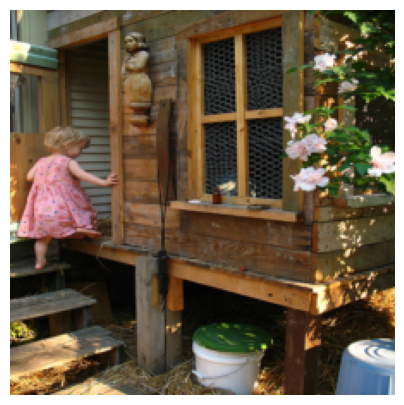

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [9]:
def plot_img(image, captions, stringify=True):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.show()
    for caption in captions:
        if stringify:
            print(f"Caption: {' '.join([token for token in caption if token not in SPECIAL_TOKENS])}")
        else:
            print(f"Caption: {caption}")

# get a picture and caption
full_dataset_iter = iter(Flickr8kDataSet(ann))
images, captions, _ = next(full_dataset_iter)
plot_img(images, captions)

Jetzt erstellen wir das DataModule. In diesem werden die Daten geladen, in Train-, Val- und Testset aufgeteilt und die DataLoader erstellt.

In [10]:
class Flickr8kDataModule(li.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage=None):
        # split by image
        images = ann.image.unique()
        
        # calculate splitsizes
        n_images = len(images)
        n_val_samples = int(n_images * VAL_RATIO)
        n_test_samples = int(n_images * TEST_RATIO)

        # split
        torch.manual_seed(27112000)
        image_split = random_split(
            images,
            [
                n_images - n_val_samples - n_test_samples,
                n_val_samples,
                n_test_samples,
            ]
        )

        # retrieve image from split
        train_images = images[image_split[0].indices]
        val_images = images[image_split[1].indices]
        test_images = images[image_split[2].indices]
        
        # convert to df for dataset
        train_ann = ann[ann["image"].isin(train_images)]
        val_ann = ann[ann["image"].isin(val_images)]
        test_ann = ann[ann["image"].isin(test_images)]

        # get datasets
        self.train_dataset = Flickr8kDataSet(train_ann)
        self.val_dataset = Flickr8kDataSet(val_ann)
        self.test_dataset = Flickr8kDataSet(test_ann)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Wir erstellen dieses DataModule und schauen uns ein Beispiel an.

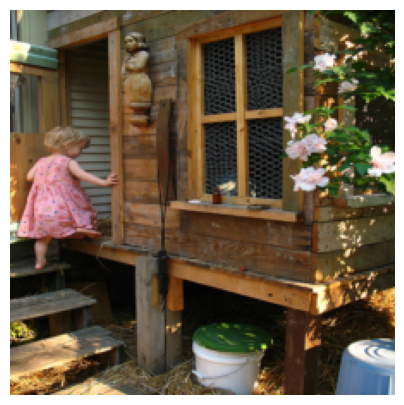

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [11]:
flickr8k = Flickr8kDataModule()
flickr8k.setup()

images, captions, caption_tensor = flickr8k.train_dataset[0]
plot_img(images, captions)

Seems to be working :)

### Schritt 2: Aufbau Modellierung 
Hier erstellen wir das Modell. Als Vorbereitung erstellen wir dafür einen `ImageEncoder`, welches die Bilder in numerische Features umwandelt, einen `CaptionEncoder`, welches die Tokens mit den gleichen Dimensionen Embedded und einen `CaptioningDecoder`, welcher das LSTM trainiert und neue Tokens vorhersagt.

Der `ImageEncoder` ist so aufgebaut, dass verschiedene EfficinetNets, ResNets, VGGs und ViTs verwendet werden können. Anstatt den letzten Layer zu trainieren, wird der letzte Layer ersetzt und ein Dropout Layer mit nachfolgendem Linear Layer hinzugefügt. Somit kann Overfitting verhindert werden. Im Paper wird angegeben, dass Dropout das Modell noch besser gemacht hat.

In [12]:
class ImageEncoder(torch.nn.Module):
    def __init__(self, cnn_model, embed_size, p_dropout):
        super().__init__()

        try:
            # load the model
            self.model = torchvision.models.get_model(cnn_model, weights="DEFAULT")

            # freeze all the layers
            for param in self.model.parameters():
                param.requires_grad = False

            # replace the classifier layer on efficientnet
            if cnn_model.startswith("efficientnet"):
                self.model.classifier = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the fc layer on resnet
            elif cnn_model.startswith("resnet"):
                self.model.fc = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.fc.in_features, embed_size),
                )

            # replace the last classifier layer on vgg
            elif cnn_model.startswith("vgg"):
                self.model.classifier[-1] = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the head layer on vit
            elif cnn_model.startswith("vit"):
                self.model.heads.head = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.heads.head.in_features, embed_size),
                )

            else:
                raise ValueError(f"Transfer Learning on Model {cnn_model} not implemented!")
            
        except Exception as e:
            raise ValueError(f"Cannot load model {cnn_model}!") from e

    def forward(self, x):
        return self.model(x)
    
class CaptionEncoder(torch.nn.Embedding):
    def __init__(self, vocab_size, embed_size):
        # initialize the nn.Embedding base class
        super().__init__(vocab_size, embed_size)

class CaptioningDecoder(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass
        output, _ = self.lstm(input)
        output = self.linear(output)

        # softmaxing
        return torch.nn.functional.log_softmax(output, dim=-1)

Hier testen wir, ob unsere Encoder und Decoder funktionieren.

In [13]:
# Parameters for testing
cnn_model = "efficientnet_b0" # list of models: torchvision.models.list_models()
embed_size = 400
p_dropout_cnn = 0.2
hidden_size_lstm = 1000
num_layers_lstm = 1

# Test Image Encoder dimensions
img_encoder = ImageEncoder(cnn_model, embed_size, p_dropout_cnn)
img_encoder_out = img_encoder(images.unsqueeze(0))
assert img_encoder(images.unsqueeze(0)).shape[1] == embed_size
print("Image Encoder: OK")
print(f"Image Encoder Output Shape: {img_encoder_out.shape}\n")

# Test Caption Encoder dimensions
cap_encoder = CaptionEncoder(VOCAB_SIZE, embed_size)
cap_encoder_out = cap_encoder(caption_tensor)
assert cap_encoder_out.shape[2] == embed_size
print("Caption Encoder: OK")
print(f"Caption Encoder Output Shape: {cap_encoder_out.shape}\n")

# Print concatenation dimensions
encoded_input = torch.cat((img_encoder_out.unsqueeze(1), cap_encoder_out[0,:,:].unsqueeze(0)), 1)
print(f"Encoded Input Shape: {encoded_input.shape}\n")

# Test Caption Decoder dimensions
cap_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, VOCAB_SIZE, num_layers_lstm)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == VOCAB_SIZE
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Image Encoder: OK
Image Encoder Output Shape: torch.Size([1, 400])

Caption Encoder: OK
Caption Encoder Output Shape: torch.Size([5, 40, 400])

Encoded Input Shape: torch.Size([1, 41, 400])



Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


Seems to be working :)

Die Encoder und Decoder werden im `ShowAndTell` Modell zusammengeführt. <br>
Hier ist es wichtig anzumerken, dass die `forward` Methode des Modells nur im während dem Training verwendet wird, da beim Vorhersagen die Caption nicht bekannt ist und somit nicht mitgegeben werden kann. Um eine Caption aus nur einem Bild zu generieren, wird die `predict` Methode verwendet.<br>
Auch noch Wissenswert: Bei der `forward` Methode wird automatisch Teacher Forcing verwendet. [Melchior, M. (2023, November 20). Teacher Forcing in PyTorch. Spaces.](https://spaces.technik.fhnw.ch/spaces/deep-learning/beitraege/teacher-forcing-in-pytorch#teacher-forcing-in-pytorch)

In [14]:
class ShowAndTell(li.LightningModule):
    def __init__(self, optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_lstm, num_layers_lstm, max_caption_length):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.cnn_model = cnn_model
        self.embed_size = embed_size
        self.p_dropout_cnn = p_dropout_cnn
        self.vocab_size = vocab_size
        self.hidden_size_lstm = hidden_size_lstm
        self.num_layers_lstm = num_layers_lstm
        self.max_caption_length = max_caption_length
        
        # initializing the submodules
        self.img_encoder = ImageEncoder(self.cnn_model, self.embed_size, self.p_dropout_cnn)
        self.caption_encoder = CaptionEncoder(self.vocab_size, self.embed_size)
        self.captioning_decoder = CaptioningDecoder(self.embed_size, self.hidden_size_lstm, self.vocab_size, self.num_layers_lstm)
        
        # loss function 
        self.loss_function = nn.CrossEntropyLoss()

        # metrics
        self.bleu1_metric = BLEUScore(n_gram=1)
    
    def forward(self, images, captions):
        # encode the images and captions
        embedded_images = self.img_encoder(images).unsqueeze(1)

        # iterate through the captions
        decoded_captions = torch.zeros((captions.shape[1], captions.shape[0], captions.shape[2]+1, self.vocab_size), device=images.device)
        for i, caption in enumerate(captions.permute(1, 0, 2)):
            # encode the captions
            embedded_captions = self.caption_encoder(caption)

            # concatenate the images and captions
            embedded_captions = torch.cat((embedded_images, embedded_captions), 1)

            # decode the captions
            decoded_caption = self.captioning_decoder(embedded_captions)
            decoded_captions[i] = decoded_caption

        # decode the captions
        return decoded_captions
    
    def predict(self, images, max_caption_length=None):
        with torch.no_grad():

            # set the maximum caption length if not specified
            if max_caption_length is None:
                max_caption_length = self.max_caption_length

            # encode the images
            embedded_images = self.img_encoder(images).unsqueeze(1)

            # initialize the caption with the start token
            current_tokens = torch.tensor(tokens_str_to_int([START_TOKEN]), device=images.device)
            current_tokens = current_tokens.repeat(len(images), 1)

            for _ in range(max_caption_length-1):
                # encode the current tokens
                embedded_captions = self.caption_encoder(current_tokens)
                embedded_captions = torch.cat((embedded_images, embedded_captions), 1)
                
                # decode the captions
                output = self.captioning_decoder(embedded_captions).argmax(dim=-1)

                # append the predicted token to the current tokens
                current_tokens = torch.cat((current_tokens, output[:,-1:]), 1)

            return current_tokens
        
    def _step(self, batch, batch_idx):
        # forward pass
        images, _, captions = batch
        outputs = self(images, captions)[:, :, :-1, :] # remove last token, because it is not used as input
        captions = captions.permute(1, 0, 2)
        
        # calculate loss
        loss = self.loss_function(outputs.reshape(-1, VOCAB_SIZE), captions.reshape(-1))

        # return loss
        return loss
            
    def training_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('val_loss', loss)

    def test_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        # define the optimizer
        match self.optimizer:
            case "SGD":
                return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case "Adam":
                return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 
            case "AdamW":
                return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.optimizer} not supported!")

Hier machen wir einen Testlauf mit dem Modell, um zu schauen, ob es funktioniert.

In [15]:
model = ShowAndTell(
    optimizer="Adam",
    lr=0.0001,
    weight_decay=0.001,
    cnn_model="efficientnet_b0",
    embed_size=512,
    p_dropout_cnn=0.5,
    vocab_size=VOCAB_SIZE,
    hidden_size_lstm=1000,
    num_layers_lstm=1,
    max_caption_length=MAX_CAPTION_LENGTH,
)

trainer = li.Trainer(
    max_epochs=1,
    log_every_n_steps=1,
    fast_dev_run=2,
    enable_progress_bar=True,
)

trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Das Modell hat beim Testlauf keinen Fehler geworfen. Seems to be working :)

### Schritt 3: Training

Ich optimiere mein Modell jetzt auf folgende Hyperparameter:
- Optimizer: `Adam`
  - SGD wurde zwar im Paper verwendet, gab bei meinen Tests jedoch suboptimale Resultate.
- Lernrate (lr): `0.001` oder `0.0003`
  - Die Lernrate wurde im Paper nicht erwähnt. Da Adam verwendet wird, habe ich kleine Lernraten gewählt.
- L2 Regularisierung (weight_decay): `0.00001`
  - Die L2 Regularisierung wurde im Paper nicht erwähnt. Da ich aber beim CNN bereits Dropout verwende, wähle ich hier einen kleinen Wert.
- CNN Modell: `efficientnet_b0` oder `vgg11` oder `resnet18`
  - Ich will verschiedene Modelle testen, um zu sehen, welches am besten funktioniert. Ich nehme hier die kleinsten Modelle, um keinen zu grossen Rechenaufwand beim Grid Search zu haben. Danach kann ich die grössere Version dieser Architekturen testen.
- Embedding Grösse (embed_size): `512`
  - Diese Embedding Grösse wurde im Paper verwendet, deswegen verwende ich sie auch.
- Dropout Wahrscheinlichkeit (p_dropout_cnn): `0.2` oder `0.5`
  - Hier will ich schwache und starke Regularisierung und deren Auswirkung auf die Generalisierbarkeit des Modells testen.
- LSTM Memory (hidden_size_lstm): `512`
  - Diese Hidden Size wurde im Paper verwendet, deswegen verwende ich sie auch.
- Anzahl der LSTM Layer (num_layers_lstm): `1` oder `2`
  - Im Paper wurden hier keine spezifische Anzahl Layer erwähnt. Hier teste ich den Unterschied zwischen einem und zwei Layer.
- Anzahl Epochen (n_epochs): `30`
  - Hier wähle ich eine etwas grosse Anzahl Epochen, da ich in vorherigen Tests gesehen habe, dass es bis hier am meisten lernt.

Insgesamt haben wir hier 24 verschiedene Modelle, welche wir trainieren.

In [16]:
sweep_config = {
    "method": "grid",
    "name": "ShowAndTell",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001, 0.0003]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["efficientnet_b0", "vgg11", "resnet18"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5, 0.2]},
        "hidden_size_lstm": {"values": [512]},
        "num_layers_lstm": {"values": [1, 2]},
        "n_epochs": {"values": [30]},
    },
}

def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTell(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_lstm=config.hidden_size_lstm,
            num_layers_lstm=config.num_layers_lstm,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [17]:
#sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
#wandb.agent(sweep_id, train)
#wandb.finish()

Sweep Ergebnisse:
https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/sweeps/ayqrrm4i

Bei diesem Sweep konnte ich folgende Kenntnisse gewinnen:
- Mit einer Learning Rate von `0.001` fing das Modell an zu Overfitten. Nach wenigen Epochen wurde aber bereits ein sehr tiefer Wert erreicht. Hier muss entweder eine kleinere Lernrate gewählt werden und länger trainiert oder ein früheres Stoppen des Trainings (Early Stopping) werden.
- Beim LSTM gaben Modelle mit `2` Layer schlechtere Resultate als der Modelle mit nur `1` einem Layer. Es sieht so aus, als würde ein zweites Layer zu Overfitting führen.
- Bei der Wahl des CNNs haben alle Modelle in etwa gleich stark performed. Die Differenz zwischen den verschiedenen Modellen war nicht signifikant.
- Die Differenz zwischen einer Dropout Wahrscheinlichkeit von `0.2` und `0.5` war auch nicht signifikant.

Deswegen werde ich für die nächsten Tests folgende Hyperparameter anzupassen:
- Lernrate (lr): `0.001 mit EarlyStopping`
- LSTM Layer (num_layers_lstm): `1`
- CNN Model (cnn_model): `ResNet18 oder grösser`
- Dropout Wahrscheinlichkeit (p_dropout_cnn): `0.5`

In [18]:
# Hier passe ich die neuen Hyperparameter an.
sweep_config = {
    "method": "grid",
    "name": "ShowAndTell2",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["resnet18", "resnet152"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5]},
        "hidden_size_lstm": {"values": [512]},
        "num_layers_lstm": {"values": [1]},
        "n_epochs": {"values": [30]},
    },
}

# Hier füge ich beim Training das Early Stopping hinzu.
def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTell(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_lstm=config.hidden_size_lstm,
            num_layers_lstm=config.num_layers_lstm,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
            callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=0)]
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [19]:
#sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
#wandb.agent(sweep_id, train)
#wandb.finish()

Sweep Ergebnisse:
https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/sweeps/x5ls3sgp

Bei diesem Sweep konnte ich folgende Kenntnisse gewinnen:
- Durch das wenige Rauschen im Validierungsloss funktioniert Early Stopping gut.
- Ein grösseres CNN als Image Encoder führt zu einem besseren Validierungsloss des Captioning Modells, hat aber als Drawback die höhere Inference Zeit.

### Schritt 4: Evaluation

In diesem Abschnitt evaluiere ich das beste Modell (tiefster Validierungsloss) vom Training. 

Hier laden wir von wandb das beste Modell.

In [20]:
# Download model as wandb artifact
model_artifact = wandb.Api().artifact('gabrieltorresgamez/fhnw-del-mc2/model-j5l55qmg:v0', type='model')
model_path = model_artifact.file('./artifacts/best_model')

# Load the weights into the model
model = ShowAndTell.load_from_checkpoint(
    model_path, 
    optimizer="Adam", 
    lr=0.001, 
    weight_decay=0.00001, 
    cnn_model="resnet152", 
    embed_size=512, 
    p_dropout_cnn=0.5, 
    vocab_size=VOCAB_SIZE, 
    hidden_size_lstm=512, 
    num_layers_lstm=1, 
    max_caption_length=MAX_CAPTION_LENGTH,
).to(DEVICE)

Danach lassen wir alle Bilder durch das Modell laufen, generieren die Captions und speichern alles ab.

In [21]:
model.to(DEVICE).eval()

# Predict every image in the test set and save the predictions
predictions = defaultdict(list)
for batch in tqdm(iter(flickr8k.test_dataloader())):
    images, captions, captions_int = batch
    images, caption_int = images.to(DEVICE), captions_int.to(DEVICE)
    outputs = model.predict(images, 40)

    predictions["images"].append(images)

    captions_ = [[[captions[j][i][k] for i in range(len(captions[0]))] for j in range(len(captions))] for k in range(len(captions[0][0]))]
    predictions["captions"].append([[" ".join([token for token in caption if token not in SPECIAL_TOKENS]) for caption in captions] for captions in captions_])

    predictions["outputs"].append([" ".join([token for token in tokens_int_to_str(caption) if token not in SPECIAL_TOKENS]) for caption in outputs.tolist()])

# Concatenate the predictions
predictions["images"] = torch.cat(predictions["images"])
predictions["captions"] = sum(predictions["captions"], [])
predictions["outputs"] = sum(predictions["outputs"], [])

  0%|          | 0/19 [00:00<?, ?it/s]

Für die Metriken erstellen wir einen Vergleich zwischen den Outputs und den tatsächlichen Captions.

In [22]:
# Generate a comparison lists 
outputs = []
captions = []
for i in range(len(predictions["outputs"])):
    outputs.append(predictions["outputs"][i])
    captions.append(predictions["captions"][i])

Danach berechnen wir alle Metriken.

In [23]:
bleu1 = BLEUScore(n_gram=1)(outputs, captions)
bleu2 = BLEUScore(n_gram=2)(outputs, captions)
bleu3 = BLEUScore(n_gram=3)(outputs, captions)
bleu4 = BLEUScore(n_gram=4)(outputs, captions)

print(f"BLEU-1:\t\t{bleu1:.4f}")
print(f"BLEU-2:\t\t{bleu2:.4f}")
print(f"BLEU-3:\t\t{bleu3:.4f}")
print(f"BLEU-4:\t\t{bleu4:.4f}")

BLEU-1:		0.5666
BLEU-2:		0.3501
BLEU-3:		0.2194
BLEU-4:		0.1402


Hier erkennen wir, dass der BLEU-1 Scores doch viel besser sind als beim Training des ersten ShowAndTell Modell. Dies deutet darauf hin, dass die Implementation des BLEU-1 Scores inkorrekt war. Man sollte also immer die Scores mit anderen Modellen oder dem Paper vergleichen, um zu sehen, ob die Scores Sinn machen.

Im Paper wird für den Flickr8k Datensatz ein BLEU-1 Score von 63 (`0.63`) gegeben. Wir haben hier einen etwas tieferen Score von ~57 (`0.5666`) erhalten, was darauf hindeutet, dass unser Modell fast so gut wie das Modell vom Paper performt aber es noch Verbesserungspotenzial gibt. Das ist erstaunlich, vorallem weil wir nur 17 Epochen (9min auf einer NVIDIA RTX A4500) trainiert haben.

Jedoch könnten wir noch mehr probieren, um die Performance zu verbessern:
- `Tiefere Lernrate und länger trainieren`
- `Andere Optimizer probieren`
- `Anders Tokenisieren`
- `Grössere Embedding Size`
- `Vortrainierte Embeddings nutzen`
- `Grossschreibung wegnehmen`
- `Beim LSTM eine grössere Hidden Size probieren`
- `Mehr Regularisierung einbauen und länger trainieren`
- `Beam Search implementieren`
- `Weitere CNNs wie z.B. ViT probieren`
- `Attention im CNN implementieren (ShowAttendAndTell)`
- `Mehr Daten nutzen (z.B. Flickr30k)`
- `LSTM mit anderen Architekturen austauschen (z.B. GRU, Transformer)`

Zum Abschluss schauen wir uns noch ein paar Beispiele an.

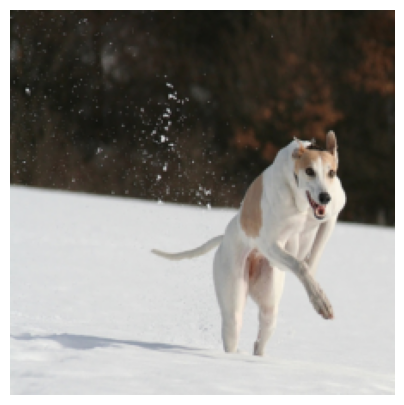

Caption: A brown and white dog is running through the snow .
Caption: A dog is running in the snow
Caption: A dog running through snow .
Caption: a white and brown dog is running through a snow covered field .
Caption: The white and brown dog is running over the surface of the snow .

Prediction: A dog runs through the snow .


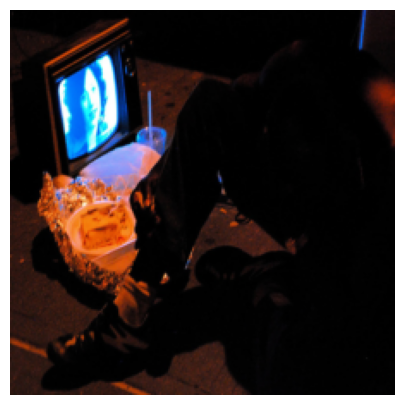

Caption: A person eats takeout while watching a small television .
Caption: A person sits on the floor and eats in front of a television .
Caption: A television with a picture of a girl on it .
Caption: A young man sits on the floor by the television with a fast food meal in front of him .
Caption: Someone is laying in front of the TV eating food .

Prediction: A man is sitting on a bench with a woman in a black shirt and a brown jacket .


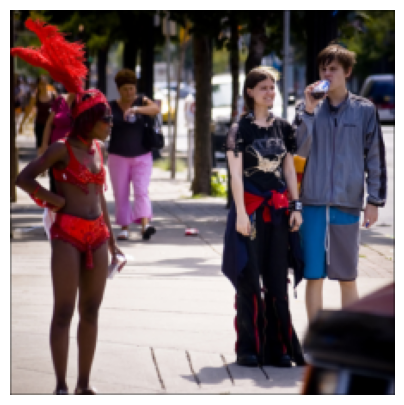

Caption: A woman in a red costume to the left of a man and woman standing together .
Caption: A woman wearing a red costume looks at two other people standing on a street .
Caption: A young woman in a red sequined costume and feather stands on the sidewalk .
Caption: The girl in the salmon colored bikini is standing next to two young people ; one is wearing a black outfit and the other is drinking pop .
Caption: Two young people are approached by a flamboyant young woman dressed in a red bikini and a red feathered headress .

Prediction: A group of people are walking down a street with a city .


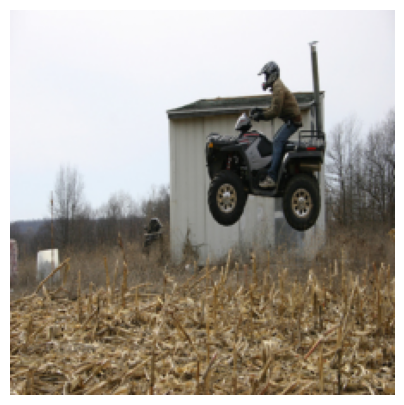

Caption: A man jumps gin the air while riding an ATV
Caption: A man on a four-wheeler jumps near a small building .
Caption: An ATV is airborne over a field in front of a white structure .
Caption: A person dressed in a tan jacket jumps a quad over a harvested cornfield in front of a small out building .
Caption: Man on four wheeler in the air .

Prediction: A man is riding a bike through a dirt field .


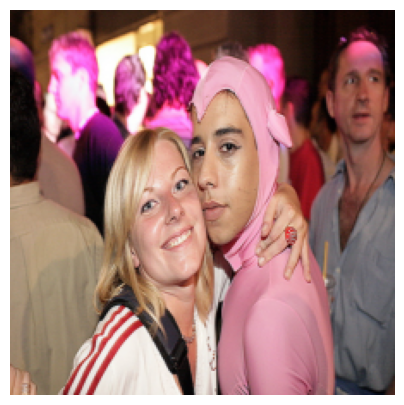

Caption: A blond woman poses with a person in a pink costume .
Caption: A smiling woman holds a person dressed in a pig costume .
Caption: A young woman hugs a young man who 's wearing a pink costume .
Caption: Blond embracing young man in pink costume , at event
Caption: Two people are hugging and one is wearing a pink-hooded stretch top .

Prediction: A woman in a red shirt is holding a camera .


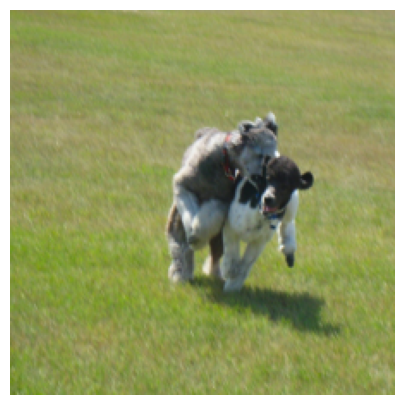

Caption: A grey dog beside a black and white dog running in green grass .
Caption: two dogs are wrestling in a grassy field .
Caption: two dogs , playing in a field , wrestling with each other
Caption: Two dogs run along a grassy field while one bites the other .
Caption: Two dogs wrestle in a field .

Prediction: A dog runs through a field .


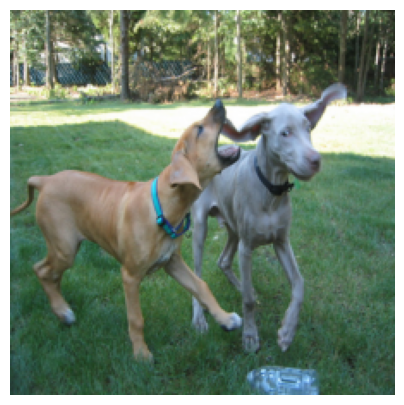

Caption: A brown dog biting a gray dogs ear .
Caption: Brown dog biting a grey dogs ear .
Caption: Tan dog on grass with mouth open , about to bite gray dog 's ear .
Caption: Two dogs are playing in a grassy field ; one dog is biting the ear of the other dog .
Caption: Two dogs are playing together on green grass .

Prediction: A brown dog is running on a grassy field .


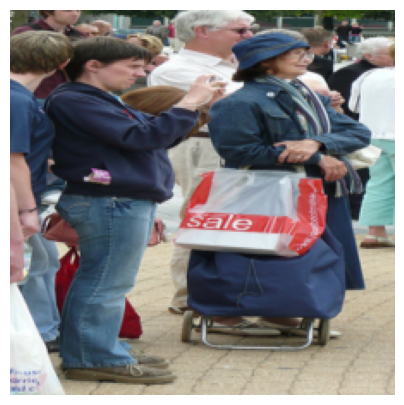

Caption: A crowd of people look at something out of frame , one man takes a picture .
Caption: A group of people stop to look at something while one takes a picture .
Caption: A woman with a shopping bag labeled `` sale `` stands in a crowd next to a young man with a camera .
Caption: The man is taking a picture while the crowd gathers .
Caption: The woman in glasses is holding a red and white sale bag .

Prediction: A man and woman are standing in front of a store .


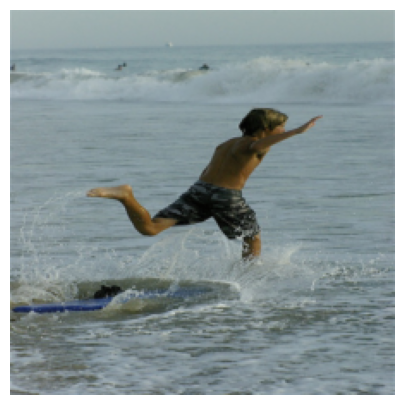

Caption: A boy is jumping from a body board into the ocean .
Caption: A boy splashing through the ocean .
Caption: A child running through the water .
Caption: A young boy running with a boogie board into the water
Caption: The little boy runs into the ocean .

Prediction: A man in a wetsuit is surfing .


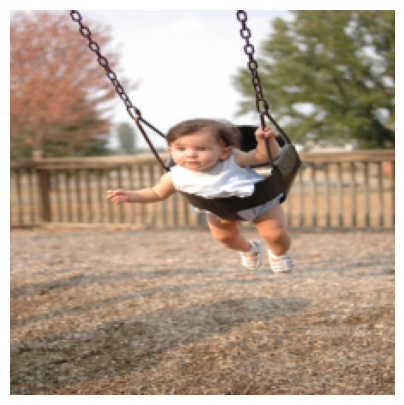

Caption: A baby swings in a swing near a wooden fence .
Caption: A baby wearing all white swinging on a swing .
Caption: A little girl is swinging in a baby swing on the playground .
Caption: A little girl rides in a child 's swing .
Caption: a young baby girl wearing a white outfit swinging in a baby swing

Prediction: A boy is jumping on a trampoline in the air .


In [24]:
for i in range(10):
    plot_img(predictions["images"][i*5].cpu(), predictions["captions"][i*5], stringify=False)
    print(f"\nPrediction: {predictions['outputs'][i*5]}")

Bei den Beispielen im Testdatensatz sehen wir, dass unsere Modell auf einige Bilder gut und auf einige eher schlechter funktioniert. <br>
Es erkennt meistens bestimmte Muster im Bild gut, macht jedoch bei Details einige Fehler. <br>
Das Verhalten ist bekannt und wird auch im Paper erwähnt. 

---

### Schritt 5: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  